In [1]:
#출처: https://towardsdatascience.com/implementing-neural-machine-translation-using-keras-8312e4844eb8

In [52]:
import pandas as pd
import numpy as np
import string
import os
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

In [53]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
lang = 'deu'
#lang = 'jpn'
#lang = 'kor'

In [55]:
# Path to the data txt file on disk.

data_path = "/content/drive/My Drive/Colab Notebooks/"+lang+"-eng/"+lang+".txt"
file_path = "/content/drive/My Drive/Colab Notebooks/"+lang+"-eng"
print(data_path)

/content/drive/My Drive/Colab Notebooks/deu-eng/deu.txt


In [56]:


lines= pd.read_table(data_path,  names =['source', 'target', 'comments'])
#printing sample data from lines
lines.sample(6)

,source,target,comments
156207,Tom rides his bicycle every day.,Tom fährt jeden Tag mit dem Fahrrad.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
35876,We don't know that.,Wir wissen das nicht.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
121353,You can't force Tom to stay.,Du kannst Tom nicht zwingen zu bleiben.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
109646,Tom received an invitation.,Tom bekam eine Einladung.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
16138,We took showers.,Wir duschten.,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
130001,We set a trap to catch a fox.,"Wir haben eine Falle gelegt, um einen Fuchs zu...",CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [57]:
# convert source and target text to Lowercase 
lines.source=lines.source.apply(lambda x: x.lower())
lines.target=lines.target.apply(lambda x: x.lower())
# Remove quotes from source and target text
lines.source=lines.source.apply(lambda x: re.sub("'", '', x))
lines.target=lines.target.apply(lambda x: re.sub("'", '', x))
# create a set of all special characters
special_characters= set(string.punctuation)
# Remove all the special characters
lines.source = lines.source.apply(lambda x: ''.join(char1 for char1 in x if char1 not in special_characters))
lines.target = lines.target.apply(lambda x: ''.join(char1 for char1 in x if char1 not in special_characters))
# Remove digits from source and target sentences
num_digits= str.maketrans('','', digits)
lines.source=lines.source.apply(lambda x: x.translate(num_digits))
lines.target= lines.target.apply(lambda x: x.translate(num_digits))
# Remove extra spaces
lines.source=lines.source.apply(lambda x: x.strip())
lines.target=lines.target.apply(lambda x: x.strip())
lines.source=lines.source.apply(lambda x: re.sub(" +", " ", x))
lines.target=lines.target.apply(lambda x: re.sub(" +", " ", x))

print('lines.shape:',lines.shape)

lines.shape: (260434, 3)


In [20]:
from collections import Counter

word_counts = Counter()

def word_count(docs):
   
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        # 문서 내에 단어를 모두 카운트 
        # ex) 'I studied, studied and studied.' -> ('I', 1), ('studied', 3), ('and', 1)
        word_counts.update(doc)
        # set -> 중복된 요소는 포함하지 않음
        # 문서 내에 단어가 한 번 이상 등장했는지 카운트 ex) 'I studied, studied and studied.' -> ('I', 1), ('studied', 1), ('and', 1)
        word_in_docs.update(set(doc))
    
    # 단어와 카운트 횟수로 dataframe을 만들어주기 위해 묶어줍니다
    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저 나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    # 전체 문서에 등장한 모든 단어 수
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    #단어 누적 합을 계산할 때, 많이 등장한 단어부터 더해주기 위해 정렬
    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    #'word_in_docs' : 해당 단어를 포함하고 있는 문서(doc)의 수
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)

tokens = []

for doc in tokenizer.pipe(lines['source']):
    #각 문서의 토큰마다 소문자 변환 및 정규표현식(영소문자 및 영어를 제외하고 모두 제거)를 적용
    doc_tokens = [re.sub(r"[^a-z0-9]", "", token.text.lower()) for token in doc]
    tokens.append(doc_tokens)

wc = word_count(tokens)

print('wc.shape:',wc.shape)

wc.shape: (17260, 7)


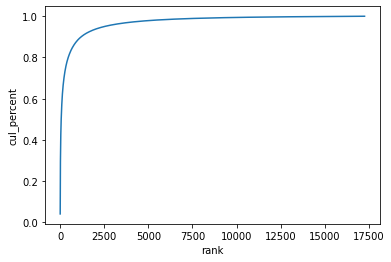

In [25]:
import seaborn as sns

sns.lineplot(x='rank', y='cul_percent', data=wc);
     

In [46]:
wc[wc['rank'] <= 1000]['cul_percent'].max()

0.8849984473347489

In [49]:
wc[wc['rank'] <= 2000]['cul_percent'].max()

0.9374236250371116

In [50]:
wc[wc['rank'] <= 5000]['cul_percent'].max()

0.9788819224007949

In [51]:
wc[wc['rank'] <= 10000]['cul_percent'].max()

0.9942743562537507

In [58]:
#wc2 = wc[wc['word_in_docs_percent'] <= 0.01]
wc2 = wc[wc['rank'] >= 5000]


def word2idx(sent):
    sent_token = sent.split()
    return [1 if word in sent_token else 0 for word in wc2['word']]

def word2idx2(sente):
    return sum(word2idx(sente))

lines['tag'] = lines['source'].apply(word2idx2)
lines2 = lines[lines['tag'] == 0]


print('lines.shape:',lines2.shape)
print('wc.shape:', wc2.shape)

lines.shape: (230907, 4)
wc.shape: (12261, 7)


In [37]:
lines2.to_csv(file_path+"/lines2.csv")

In [5]:
data_path = file_path+"/lines2.csv"

lines2= pd.read_csv(data_path, index_col=0, names=['ID', 'source', 'target', 'comments', 'tag'])

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [22]:
#lines2.sample(frac=0.5, random_state=42)
lines2 = lines2.sample(n=80000, random_state=42)

print('lines.shape:',lines2.shape)

lines.shape: (80000, 4)


In [37]:
# Add start and end tokens to target sequences
lines2.target = lines2.target.apply(lambda x : 'START_ '+ x + ' _END')
lines2.sample(6)



# Find all the source and target words and sort them
# Vocabulary of Source language
all_source_words=set()
for source in lines2.source:
    for word in source.split():
        if word not in all_source_words:
            all_source_words.add(word)
# Vocabulary of Target 
all_target_words=set()
for target in lines2.target:
    for word in target.split():
        if word not in all_target_words:
            all_target_words.add(word)
# sort all unique source and target words
source_words= sorted(list(all_source_words))
target_words=sorted(list(all_target_words))

#Find maximum sentence length in  the source and target data
source_length_list=[]
for l in lines2.source:
    source_length_list.append(len(l.split(' ')))
max_source_length= max(source_length_list)
print(" Max length of the source sentence",max_source_length)
target_length_list=[]
for l in lines2.target:
    target_length_list.append(len(l.split(' ')))
max_target_length= max(target_length_list)
print(" Max length of the target sentence",max_target_length)

# creating a word to index(word2idx) for source and target
source_word2idx= dict([(word, i+1) for i,word in enumerate(source_words)])
target_word2idx=dict([(word, i+1) for i, word in enumerate(target_words)])

#creating a dictionary for index to word for source and target vocabulary
source_idx2word= dict([(i, word) for word, i in  source_word2idx.items()])
print(source_idx2word)
target_idx2word =dict([(i, word) for word, i in target_word2idx.items()])

#Shuffle the data
lines2 = shuffle(lines2)

# Train - Test Split
X, y = lines2.source, lines2.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
print(X_train.shape, X_test.shape)

################

# Input tokens for encoder
num_encoder_tokens=len(source_words)
# Input tokens for decoder zero padded
num_decoder_tokens=len(target_words) +1

/usr/local/lib/python3.9/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


 Max length of the source sentence 25
 Max length of the target sentence 27
{1: 'a', 2: 'able', 3: 'about', 4: 'abroad', 5: 'accept', 6: 'accident', 7: 'across', 8: 'actually', 9: 'address', 10: 'advice', 11: 'afford', 12: 'afraid', 13: 'after', 14: 'afternoon', 15: 'again', 16: 'against', 17: 'age', 18: 'ago', 19: 'agree', 20: 'air', 21: 'airport', 22: 'alice', 23: 'alive', 24: 'all', 25: 'allowed', 26: 'almost', 27: 'alone', 28: 'along', 29: 'already', 30: 'also', 31: 'always', 32: 'am', 33: 'an', 34: 'and', 35: 'angry', 36: 'animals', 37: 'another', 38: 'answer', 39: 'answered', 40: 'any', 41: 'anybody', 42: 'anymore', 43: 'anyone', 44: 'anything', 45: 'anywhere', 46: 'apartment', 47: 'apologize', 48: 'apple', 49: 'apples', 50: 'are', 51: 'arent', 52: 'arm', 53: 'around', 54: 'arrested', 55: 'arrive', 56: 'arrived', 57: 'as', 58: 'ask', 59: 'asked', 60: 'asking', 61: 'asleep', 62: 'at', 63: 'ate', 64: 'attention', 65: 'audiobook\xad', 66: 'australia', 67: 'away', 68: 'baby', 69: 'ba

In [38]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_source_length),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_target_length),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_target_length, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                  encoder_input_data[i, t] = source_word2idx[word] 
                  for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_word2idx[word] # decoder input seq
                        if t>0:
                                          # decoder target sequence (one hot encoded)
                                          # does not include the START_ token
                                          # Offset by one timestep
                                          #print(word)
                            decoder_target_data[i, t - 1, target_word2idx[word]] = 1.
                    
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [39]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 50
latent_dim=256

In [40]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

####

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


####

# Define the model that takes encoder and decoder input 
# to output decoder_outputs
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [41]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

In [28]:
train_samples = len(X_train) # Total Training samples
val_samples = len(X_test)    # Total validation or test samples
batch_size = 128
epochs = 100


In [30]:
# 1. 저장할 폴더와 형식을 선택
checkPoint_path = file_path+"/model_{epoch}.ckpt" # 저장할 당시 epoch가 파일이름이 된다.

# 2. 콜백 변수를 생성
my_period = train_samples//batch_size
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkPoint_path,
					save_weights_only=True, verbose=1, save_freq=my_period)

print(my_period)

562


In [16]:
# 1. 체크포인트들이 있는 폴더 선택
checkPoint_dir = os.path.dirname(file_path+"/model_{epoch}.ckpt")

# 2. 해당 폴더에서 가장 마지막 체크포인트 선택
latest = tf.train.latest_checkpoint(checkPoint_dir)

# 3. 해당체크포인트에 저장한 모델의 가중치 불러오기
model.load_weights(latest)

In [31]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size,
                    callbacks=[cp_callback])

<ipython-input-31-109a3284168e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),


Epoch 1/100
561/562 [============================>.] - ETA: 0s - loss: 5.6861 - acc: 0.0541
Epoch 1: saving model to /content/drive/My Drive/Colab Notebooks/deu-eng/model_1.ckpt
562/562 [==============================] - 373s 643ms/step - loss: 5.6854 - acc: 0.0541 - val_loss: 5.3918 - val_acc: 0.0584
Epoch 2/100
561/562 [============================>.] - ETA: 0s - loss: 5.2863 - acc: 0.0750
Epoch 2: saving model to /content/drive/My Drive/Colab Notebooks/deu-eng/model_2.ckpt
562/562 [==============================] - 345s 614ms/step - loss: 5.2859 - acc: 0.0751 - val_loss: 5.1813 - val_acc: 0.0986
Epoch 3/100
561/562 [============================>.] - ETA: 0s - loss: 5.0504 - acc: 0.1213
Epoch 3: saving model to /content/drive/My Drive/Colab Notebooks/deu-eng/model_3.ckpt
562/562 [==============================] - 351s 624ms/step - loss: 5.0502 - acc: 0.1214 - val_loss: 4.9414 - val_acc: 0.1356
Epoch 4/100
561/562 [============================>.] - ETA: 0s - loss: 4.8436 - acc: 0.1464

KeyboardInterrupt: ignored

In [17]:
model.save_weights(file_path+'/nmt_weights_5000_words.h5')

In [48]:
model.evaluate(generate_batch(X_test, y_test, batch_size = batch_size),
                    steps = val_samples//batch_size,
                    )

102/102 [==============================] - 28s 211ms/step - loss: 0.9495 - acc: 0.6664


[0.9495357275009155, 0.6663960218429565]

In [42]:
model.load_weights(file_path+'/nmt_weights_1000_words.h5')
#model.load_weights(file_path+'/nmt_weights_10000_samples.h5')
#model.load_weights(file_path+'/nmt_weights_5000_words.h5')


In [43]:
# Encode the input sequence to get the "Context vectors"
encoder_model = Model(encoder_inputs, encoder_states)
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_state_input = [decoder_state_input_h, decoder_state_input_c]
# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_input)
decoder_states2 = [state_h2, state_c2]
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)
# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_state_input,
    [decoder_outputs2] + decoder_states2)

In [44]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of 
    #target sequence with the start character.
    target_seq[0, 0] = target_word2idx['START_']
# Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
# Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word =target_idx2word[sampled_token_index]
        decoded_sentence += ' '+ sampled_word
# Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True
# Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
# Update states
        states_value = [h, c]
    return decoded_sentence

In [45]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [46]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Source sentence:', X_train[k:k+1].values[0])
print('Actual Target Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Target Translation:', decoded_sentence[:-4])


1/1 [==============================] - 0s 52ms/step
Input Source sentence: tom went there in person
Actual Target Translation:  tom ging persönlich hin 
Predicted Target Translation:  tom ging persönlich hin gehen haben haben haben h


In [47]:
test_gen = generate_batch(X_test, y_test, batch_size = 1)
k=10
k+=1
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input Source sentence:', X_test[k:k+1].values[0])
print('Actual Target Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Target Translation:', decoded_sentence[:-4])

1/1 [==============================] - 0s 31ms/step
Input Source sentence: i read a book as i walked
Actual Target Translation:  ich las ein buch als ich spazieren ging 
Predicted Target Translation:  tom ist nicht sehr groß aus haben haben haben h


In [ ]:
#언어, 문장수, 단어수, 에폭을 기준으로 성능측정.
#이중번역 성능측정.


In [ ]:
#Aset에 대한 결과

Input Source sentence: i do remember
Actual Target Translation:  ich erinnere mich 
Predicted Target Translation:  ich bin nicht daran gewöhnt dass die zukunft eine nachr

Input Source sentence: tom went there in person
Actual Target Translation:  tom ging persönlich hin 
Predicted Target Translation:  tom ging persönlich hin gehen haben haben haben h


Input Source sentence: youre not supposed to be in here
Actual Target Translation:  sie sollten eigentlich nicht hier drinnen sein 
Predicted Target Translation:  dir kam gestern im park sehen zu sein haben haben h

Input Source sentence: i read a book as i walked
Actual Target Translation:  ich las ein buch als ich spazieren ging 
Predicted Target Translation:  tom ist nicht sehr groß aus haben haben haben h


 loss: 0.9495 - acc: 0.6664

In [ ]:
Cset 에 대한 결과


Input Source sentence: tom is likely to get married again
Actual Target Translation:  tom wird wahrscheinlich wieder heiraten 
Predicted Target Translation:  tom wird wahrscheinlich wieder heiraten werden zu 



Input Source sentence: whats your favorite kind of sushi
Actual Target Translation:  was ist dein lieblingssushi 
Predicted Target Translation:  wir müssen tom aufhalten bevor er sich nicht g


loss: 1.2561 - acc: 0.6408
